In [1]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import datetime as dt

path = kagglehub.dataset_download("sachinkanchan92/reddit-top-posts-50-subreddit-analysis-2011-2024")
print(f'Path to dataset files: {path}')
file_list = [f for f in os.listdir(path) if f.endswith('.csv') and f != '50_subreddits_list.csv']

Path to dataset files: /Users/patricktong/.cache/kagglehub/datasets/sachinkanchan92/reddit-top-posts-50-subreddit-analysis-2011-2024/versions/3


In [3]:
data = pd.read_csv(os.path.join(path, file_list[3]))

In [4]:
subreddit_stats_list = []
all_data = pd.DataFrame()
for file in file_list:
  df = pd.read_csv(os.path.join(path, file))
  # drop null column
  #df.drop(columns = ['crosspost_subreddits', 'body'], inplace = True)
  # Convert created_utc to datetime
  if 'created_utc' in data.columns:
        data['created_utc'] = pd.to_datetime(data['created_utc'], errors='coerce')  # Convert to datetime, handling errors
  else:
      print("Column 'created_utc' not found in this dataset.")
  # # fill null value by mode
  # df['is_nsfw'] = df['is_nsfw'].replace('True', 1)
  # df['is_nsfw'] = df['is_nsfw'].replace('False', 0)
  # df['is_bot'] = df['is_bot'].replace('True', 1)
  # df['is_bot'] = df['is_bot'].replace('False', 0)
  # df['is_megathread'] = df['is_megathread'].replace('True', 1)
  # df['is_megathread'] = df['is_megathread'].replace('False', 0)

  # Fill null value by mode
  pd.set_option('future.no_silent_downcasting', True)
  df['is_nsfw'] = df['is_nsfw'].fillna(df['is_nsfw'].mode()[0])
  df['is_bot'] = df['is_bot'].fillna(df['is_bot'].mode()[0])
  df['is_megathread'] = df['is_megathread'].fillna(df['is_megathread'].mode()[0])

  df['title'] = data['title'].str.replace(r'[^\w\s]', '', regex=True)
  df.drop_duplicates(inplace = True)


  # Calculate averages for the subreddit
  avg_score = df['score'].mean() if 'score' in df.columns else 0
  avg_upvote_ratio = df['upvote_ratio'].mean() if 'upvote_ratio' in df.columns else 0
  avg_comments = df['num_comments'].mean() if 'num_comments' in df.columns else 0
  avg_num_crossposts = df['num_crossposts'].mean() if 'num_crossposts' in df.columns else 0
  nsfw_ratio = df['is_nsfw'].mean() if 'is_nsfw' in df.columns else 0
  num_megathreads = df['is_megathread'].sum() if 'is_megathread' in df.columns else 0
  subscribers = df['subscribers'].iloc[0] if 'subscribers' in df.columns else 0

  # Append the statistics to the list
  subreddit_stats_list.append({
      'subreddit': str(file),
      'avg_score': avg_score,
      'avg_upvote_ratio': avg_upvote_ratio,
      'avg_comments': avg_comments,
      'avg_num_crossposts': avg_num_crossposts,
      'nsfw_ratio': nsfw_ratio,
      'num_megathreads': num_megathreads,
      'subscribers': subscribers
  })

  # Concatenate all cleaned csv files together in all_data
  df['subreddit'] = file
  all_data = pd.concat([all_data, df], ignore_index=True)

subreddit_stats = pd.DataFrame(subreddit_stats_list)

In [6]:
from textblob import TextBlob

In [7]:
posts = all_data[['subreddit', 'upvote_ratio', 'body']]
posts = posts.dropna()
joke_posts = posts[posts['subreddit'] == 'jokes.csv']
joke_posts = joke_posts[['upvote_ratio', 'body']]
relationship_posts = posts[posts['subreddit'] == 'relationship_advice.csv']
relationship_posts = relationship_posts[['upvote_ratio', 'body']]

In [8]:
joke_posts

,upvote_ratio,body
20549,0.98,"RIP Larry Tesler, the UI designer that created..."
20550,0.90,Paying additional money to access certain site...
20551,0.93,V\n\n*Edit: seems like the ctrl key on my keyb...
20552,0.94,"He speaks with the officer, who assigns him hi..."
20553,0.94,Imagine how surprised he must have been.\n\nEd...
...,...,...
21540,0.90,"A blonde is overweight, so her doctor puts her..."
21541,0.94,Turne‌‌d ou‌‌t i‌‌t wa‌‌s jus‌‌t ‌‌a stere‌‌o ...
21542,0.89,\nOne day a Cop pulls a van over and when he w...
21543,0.88,So he walks into a bar.\n\nThe bartender asks ...


In [9]:
def calculate_sentiment(subreddit_posts):
    for index, post in subreddit_posts.iterrows():
        blob_analysis = TextBlob(str(post['body']))
        polarity = 0.0
        max_positive_polarity = float("-inf")
        max_negative_polarity = float("inf")
        
        total_sentences = len(blob_analysis.sentences)
        for sentence in blob_analysis.sentences:
            curr_polarity = sentence.sentiment.polarity
            polarity += curr_polarity
            max_positive_polarity = max(max_positive_polarity, curr_polarity)
            max_negative_polarity = min(max_negative_polarity, curr_polarity)

        avg_polarity = polarity / total_sentences
        subreddit_posts.at[index, 'average_polarity'] = avg_polarity
        subreddit_posts.at[index, 'max_positive_polarity'] = max_positive_polarity
        subreddit_posts.at[index, 'max_negative_polarity'] = max_negative_polarity

    return subreddit_posts

In [10]:
joke_sentiment_posts = calculate_sentiment(joke_posts)
relationship_sentiment_posts = calculate_sentiment(relationship_posts)

In [11]:
def plot_sentiment_distribution(subreddit_posts):
    sentiment_X = subreddit_posts[['average_polarity', 'max_positive_polarity', 'max_negative_polarity']]
    score_bins = np.linspace(-1, 1, 22)

    for col in sentiment_X.columns:
        plt.hist(sentiment_X[col], bins=score_bins, weights=np.ones(len(sentiment_X[col])) / len(sentiment_X[col]) * 100)
        plt.xlabel(f'{col.capitalize()} Score')
        plt.ylabel('Percentage of Data (%)')
        plt.title(f'Histogram of {col.capitalize()} Scores')
        plt.show()

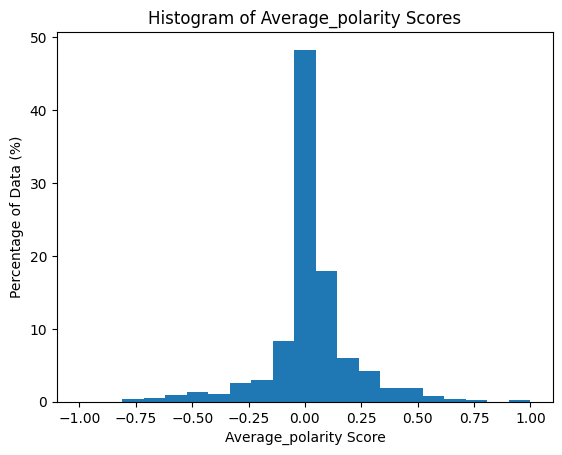

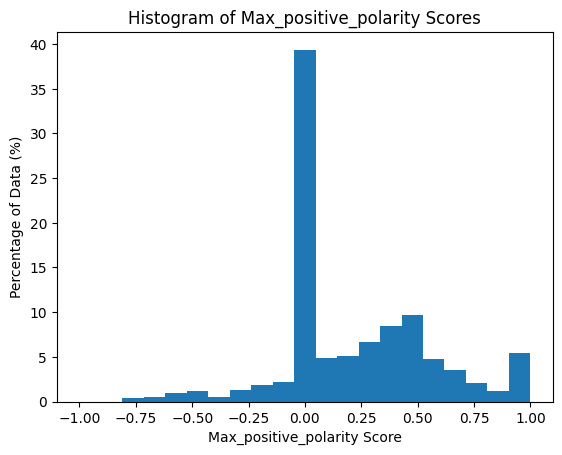

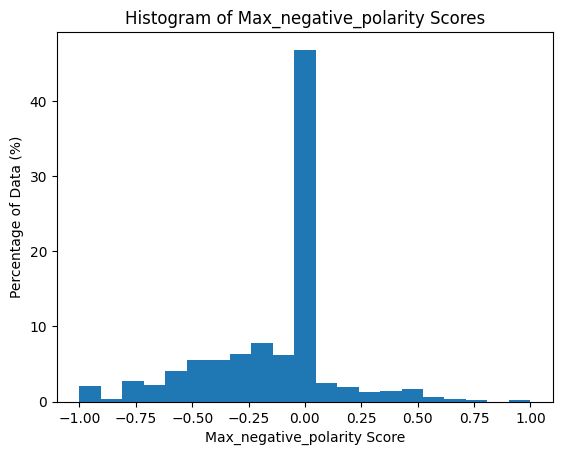

In [12]:
plot_sentiment_distribution(joke_sentiment_posts)

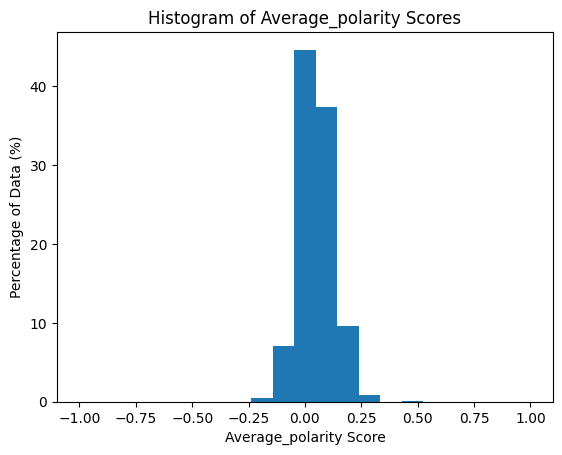

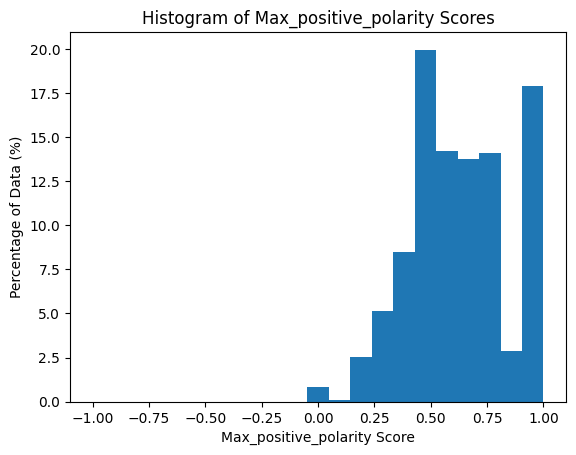

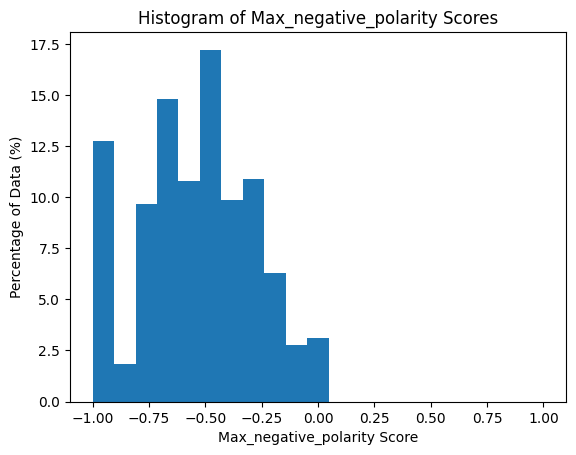

In [13]:
plot_sentiment_distribution(relationship_sentiment_posts)

### Logistic Regression Simulation #### 

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [15]:
def split_data(subreddit_posts):
    posts_y = subreddit_posts['upvote_ratio']
    posts_X = subreddit_posts.drop(columns = ['upvote_ratio', 'body'])

    X_dev, X_test, y_dev, y_test = train_test_split(posts_X, posts_y)
    return X_dev, X_test, y_dev, y_test

In [16]:
jokes_X_dev, jokes_X_test, jokes_y_dev, jokes_y_test = split_data(joke_sentiment_posts)
relationship_X_dev, relationship_X_test, relationship_y_dev, relationship_y_test = split_data(relationship_sentiment_posts)
fold = KFold(n_splits = 20, shuffle = False)

def cross_validate():
    jokes_model = LinearRegression()
    relationship_model = LinearRegression()
    joke_cross_val = cross_val_score(jokes_model, jokes_X_dev, jokes_y_dev, cv = fold, scoring = 'neg_mean_squared_error')
    relationship_cross_val = cross_val_score(relationship_model, relationship_X_dev, relationship_y_dev, cv = fold, 
                                             scoring = 'neg_mean_squared_error')

    return -joke_cross_val.mean(), -relationship_cross_val.mean()

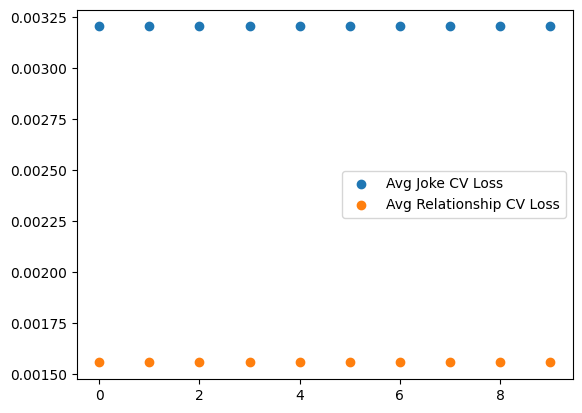

In [17]:
joke_cross_vals = []
relationship_cross_vals = []
for i in range(10):
    joke_cross_val, relationship_cross_val = cross_validate()
    joke_cross_vals.append(joke_cross_val)
    relationship_cross_vals.append(relationship_cross_val)

indices = [i for i in range(10)]
plt.scatter(indices, joke_cross_vals, label = 'Avg Joke CV Loss')
plt.scatter(indices, relationship_cross_vals, label = 'Avg Relationship CV Loss')
plt.legend()

### Decision Tree Topic Modeling ### 

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [19]:
topic_posts = posts[(posts['subreddit'] == 'history.csv') | (posts['subreddit'] == 'personalfinance.csv')]
topic_posts = topic_posts[['body', 'subreddit']]
topic_posts_X = topic_posts['body']
topic_posts_y = topic_posts['subreddit']

In [20]:
components_parameters = [3, 5, 10, 20, 50]
components_scores = []
for components in components_parameters:  
    pipeline = make_pipeline(CountVectorizer(), LatentDirichletAllocation(n_components=components), RandomForestClassifier(max_depth = 5))
    score = cross_val_score(pipeline, topic_posts_X, topic_posts_y, cv = fold)
    components_scores.append(np.mean(score))
    

In [21]:
components_scores

[0.9314285714285715,
 0.9327565392354125,
 0.9491046277665995,
 0.9532997987927565,
 0.932897384305835]

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [15]:
def split_data(subreddit_posts):
    posts_y = subreddit_posts['upvote_ratio']
    posts_X = subreddit_posts.drop(columns = ['upvote_ratio', 'body'])

    X_dev, X_test, y_dev, y_test = train_test_split(posts_X, posts_y)
    return X_dev, X_test, y_dev, y_test

In [16]:
jokes_X_dev, jokes_X_test, jokes_y_dev, jokes_y_test = split_data(joke_sentiment_posts)
relationship_X_dev, relationship_X_test, relationship_y_dev, relationship_y_test = split_data(relationship_sentiment_posts)
fold = KFold(n_splits = 20, shuffle = False)

def cross_validate():
    jokes_model = LinearRegression()
    relationship_model = LinearRegression()
    joke_cross_val = cross_val_score(jokes_model, jokes_X_dev, jokes_y_dev, cv = fold, scoring = 'neg_mean_squared_error')
    relationship_cross_val = cross_val_score(relationship_model, relationship_X_dev, relationship_y_dev, cv = fold, 
                                             scoring = 'neg_mean_squared_error')

    return -joke_cross_val.mean(), -relationship_cross_val.mean()

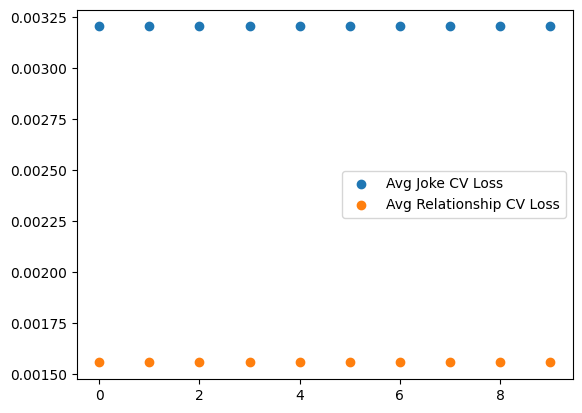

In [17]:
joke_cross_vals = []
relationship_cross_vals = []
for i in range(10):
    joke_cross_val, relationship_cross_val = cross_validate()
    joke_cross_vals.append(joke_cross_val)
    relationship_cross_vals.append(relationship_cross_val)

indices = [i for i in range(10)]
plt.scatter(indices, joke_cross_vals, label = 'Avg Joke CV Loss')
plt.scatter(indices, relationship_cross_vals, label = 'Avg Relationship CV Loss')
plt.legend()

### Decision Tree Topic Modeling ### 

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [19]:
topic_posts = posts[(posts['subreddit'] == 'history.csv') | (posts['subreddit'] == 'personalfinance.csv')]
topic_posts = topic_posts[['body', 'subreddit']]
topic_posts_X = topic_posts['body']
topic_posts_y = topic_posts['subreddit']

In [20]:
components_parameters = [3, 5, 10, 20, 50]
components_scores = []
for components in components_parameters:  
    pipeline = make_pipeline(CountVectorizer(), LatentDirichletAllocation(n_components=components), RandomForestClassifier(max_depth = 5))
    score = cross_val_score(pipeline, topic_posts_X, topic_posts_y, cv = fold)
    components_scores.append(np.mean(score))
    

In [21]:
components_scores

[0.9314285714285715,
 0.9327565392354125,
 0.9491046277665995,
 0.9532997987927565,
 0.932897384305835]